In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import os
import multiprocessing as mp

plt.style.use('seaborn')

In [509]:
# Creates a "particle tree" which is a dictionary containing
# { event0 : {ptcls} , event1 : {ptcls} , ... }
# "ptcls" contains:
# { ptclID : { "allEvents" : [] , "children" : {ptcls} } }
# where "allEvents" is every event performed by the particle with ID == ptclID
# and "children" recursively stores "ptcls" structures for each child

def buildPtclTree(filePath):
    ptclTree = {}
    
    data = np.array(pd.read_csv(filePath))
    
    IDtoRow = {}
    for row in data:
        IDtoRow[row[0]] = row

    for row in data:
        skipRow = False
        
        # Stack of parents
        IDStack = []
        ID = row[0]
        while "-0" not in ID:
            IDStack.append(ID)
            if ID not in IDtoRow:
                skipRow = True
                break
            ID = IDtoRow[ID][1]
            
        if skipRow :
            continue

        ID = 0
        currTree = ptclTree
        while True:
            ID = IDStack.pop()
            if ID not in currTree:
                currTree[ID] = {"allEvents" : [] , "children" : {} , "totalEDep" : -1}

            if len(IDStack) == 0:
                currTree = currTree[ID]
                break

            currTree = currTree[ID]["children"]

        currTree["allEvents"].append(row)
        
    return ptclTree



In [510]:
# Takes in a "ptcl" and a material name, and finds the total energy deposited 
# by this particle, and all of its children, into that material

def netEDep(ptclInTree, materialName):
    eDep = 0
    for event in ptclInTree["allEvents"]:
        if event[4] in materialName:
            eDep += event[3]
    for child in ptclInTree["children"].values():
        eDep += netEDep(child, materialName)
    ptclInTree["totalEDep"] = eDep
    return eDep

# Takes in a "ptcl" and a particle type, and if this particle or any of its
# children have that type

def hasNoChildrenOfType(ptclInTree, ptclType):
    hasChild = True
    
    if ptclInTree["allEvents"][0][2] in ptclType:
        return False
    
    for child in ptclInTree["children"].values():
        hasChild = hasChild and hasNoChildrenOfType(child, ptclType)
    
    return hasChild

# Prints a particle

def printPtcl(ptcl, indent = ">"):
    print("\n", indent , "Particle : " , ptcl["allEvents"][0][2] , " Energy : " , (ptcl["allEvents"][0][3] + ptcl["allEvents"][0][5]) / 1e3 , " keV ")
    for child in ptcl["children"].values():
        printPtcl(child, "---" + indent)
        
# Takes in a particle and finds the light generated in the scintillator 
# by the particle, or any of its children. 
# -> pRF is the "proton response function" which takes total energy deposited by a proton and 

def ptclLightYield(ptcl, pRF):
    pEDep = 0
    cEDep = 0
    
    for event in ptcl["allEvents"]:
        ptclType = event[2]
        if ptclType not in "proton C12 C13":
            break
        if event[4] not in "ej309":
            continue
        if ptclType in "proton":
            pEDep += event[3]
        if ptclType in "C12 C13":
            cEDep += event[3]
        
    
    lightYield = float( pRF( pEDep / 1e6 ) )
    for child in ptcl["children"].values():
        lightYield += ptclLightYield(child, pRF)
    
    return lightYield



In [511]:
protonLightYield = np.array(pd.read_csv("EJ309Light.txt", delimiter=' ', header = None))
x = np.append(np.array([0]), protonLightYield[:,0])
y = np.append(np.array([0]), protonLightYield[:,1])

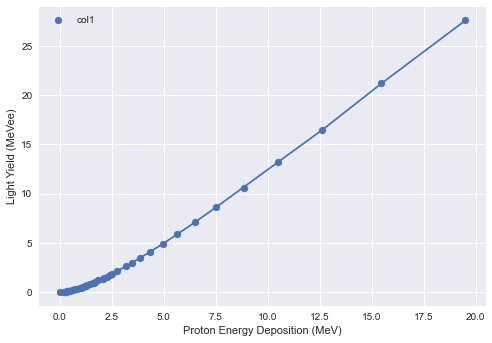

In [512]:
plt.scatter(x, y, label="col1")

def f(x, A, B, C, D, E, F, G):
    return A*x + B*x**2 + C*x**3 + D*x**4 + E*x**5 + F*x**6 + G*x**7

popt, pcov = optimize.curve_fit(f, x, y)

plt.plot(x, f(x, *popt))

plt.xlabel("Proton Energy Deposition (MeV)")
plt.ylabel("Light Yield (MeVee)")
plt.legend()

pRF = lambda x : f(x, *popt)

In [504]:
IDtoLightYield = {}
for ID in ptclTree:
    lightYield = ptclLightYield(ptclTree[ID], pRF)
    if lightYield > 0.0:
        IDtoLightYield[ID] = lightYield
lightYield = IDtoLightYield.values()

In [ ]:
def GetLightYield(data):
    
    ptclTree = buildPtclTree("../EJ309-build/data/" + data)
    
    IDtoLightYield = []
    for ID in ptclTree:
        lightYield = ptclLightYield(ptclTree[ID], pRF)
        if lightYield > 0.0:
            IDtoLightYield.append(lightYield)
            
    return np.array(IDtoLightYield)


In [704]:
dataToLightYield = { }

for filename in os.listdir("../EJ309-build/data/"):
    if filename.endswith(".csv"):
        dataToLightYield[filename] = GetLightYield(filename)

In [721]:
for key in dataToLightYield:

    value = dataToLightYield[key]

    i = key.find("_")
    ptcl = key[0:i]
    key = key[i + 1:]

    i = key.find("_")
    energy = key[0:i]
    key = key[i + 1:]

    i = key.find(".")
    unit = key[0:i]

    ptcl, energy, unit

    try:
        os.mkdir("LightOutput/"+particle+energy+unit)
    except:
        pass

    bins = plt.hist(value, bins = 60, density = True)
    plt.xlabel("Light Output (a.u.)")
    plt.ylabel("probability density")
    plt.title("Scintillator Light Yield from " 
               + energy + " " + unit + " " + ptcl)
    
    plt.ylim( 0, max(bins[0]) )
    plt.xlim( 0, max(bins[1]) * 1.2 )
    plt.savefig("LightOutput/"+particle+energy+unit+"/lightRF.png")
    
    plt.clf()

<Figure size 576x396 with 0 Axes>

In [720]:
bins

(array([2.39402888, 1.73807675, 1.5141889 , 1.32957962, 1.19014069,
        1.12533105, 1.06837712, 1.00356748, 1.03106248, 0.91911855,
        0.86609248, 0.87591213, 0.87787605, 0.85038105, 0.89751534,
        0.81699427, 0.9151907 , 0.83074177, 0.88965963, 0.8327057 ,
        0.87787605, 0.81503034, 0.76593213, 0.9014432 , 0.93679391,
        0.92108248, 0.97803641, 0.9426857 , 1.00553141, 1.08016069,
        0.96036105, 1.10176391, 0.99374784, 1.03106248, 1.11354748,
        1.02909855, 1.00945927, 1.08801641, 1.06052141, 1.12140319,
        1.01142319, 0.91322677, 0.88376784, 0.81306641, 0.87983998,
        0.75807641, 0.65791606, 0.7777157 , 0.71094213, 0.69719463,
        0.69130284, 0.69326677, 0.66184392, 0.63631284, 0.5989982 ,
        0.60488999, 0.64220463, 0.54989999, 0.58132285, 0.61863749]),
 array([1.40081937e-06, 1.78324520e-02, 3.56635032e-02, 5.34945544e-02,
        7.13256056e-02, 8.91566568e-02, 1.06987708e-01, 1.24818759e-01,
        1.42649810e-01, 1.60480862e-01